# Computer Simulation Project
Mohammad Javad Maheronnaghsh

Mohammad Mowlavi

## General Information of the Simulation

In [135]:
# Imported Libraries
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
import copy

In [210]:
class FinishProgramException(Exception):
    pass


class Task:
    TASK_ID = 1

    def __init__(self, inter_arrival=None, priority=None, execute_time=None):
        self.task_id = Task.TASK_ID
        self.inter_arrival = inter_arrival
        self.arrival = None
        self.priority = priority
        self.execution_time = execute_time
        self.start_execution_time = None
        self.end_execution_time = None
        self.processor = None
        self.gone_to_router = False
        self.dropped = False
        Task.TASK_ID += 1

    def __str__(self):
        return str(self.inter_arrival, self.priority)

    @staticmethod
    def get_next_arrival_task(all_tasks):  # all tasks are sorted
        for t in all_tasks:
            if not t.gone_to_router:
                return t
        raise FinishProgramException()

    @staticmethod
    def get_next_free_processor_task(all_tasks):
        in_progress_tasks = []
        for t in all_tasks:
            if t.start_execution_time is not None and t.end_execution_time is None:
                in_progress_tasks.append(t)
        if in_progress_tasks:
            return min(in_progress_tasks, key=lambda x: x.start_execution_time + x.execution_time)

    @staticmethod
    def set_all_arrivals(all_tasks):
        cum_sum = 0
        for t in all_tasks:
            t.arrival = cum_sum + t.inter_arrival
            cum_sum += t.inter_arrival

    def finish(self):
        self.end_execution_time = self.start_execution_time + self.execution_time

    @staticmethod
    def get_cumulative_queue_time(all_tasks, end_time, priority=None):
        cum_sum = 0
        for t in all_tasks:
            if t.arrival <= end_time and (priority is None or priority == t.priority):
                if t.start_execution_time is not None:
                    cum_sum += t.start_execution_time - t.arrival
                else:
                    cum_sum += end_time - t.arrival
            elif t.arrival >= end_time:
                break
        return cum_sum

    @staticmethod
    def get_cumulative_execution_time(all_tasks, end_time, processor):
        cum_sum = 0
        for t in all_tasks:
            if t.start_execution_time is not None and t.end_execution_time is not None:
                if t.end_execution_time <= end_time and t.processor is not None and processor == t.processor:
                    cum_sum += t.execution_time
            elif t.start_execution_time is not None and t.start_execution_time >= end_time:
                break
        return cum_sum

    @staticmethod
    def get_number_of_dropped_tasks(all_tasks):
        return sum(t.dropped for t in all_tasks)


class BaseQueue:
    def __init__(self, length_limit):
        self.length_limit = length_limit

    def get_next(self):
        raise NotImplemented

    def add_arrival_to_queue(self, task):
        raise NotImplemented


class FIFO(BaseQueue):

    def __init__(self, length_limit):
        super().__init__(length_limit)
        self.queue = []

    def get_next(self):
        try:
            return self.queue.pop(0)
        except IndexError:
            return None

    def add_arrival_to_queue(self, task):
        if len(self.queue) < self.length_limit:
            self.queue.append(task)
        else:
            task.dropped = True


class WRR(BaseQueue):

    def __init__(self, length_limit):
        super().__init__(length_limit)
        self._priority_queues = [[] for i in range(3)]

    def get_next(self):
        for priority in range(3):
            if self._priority_queues[priority]:
                return self._priority_queues[priority].pop(0)
        return None

    def add_arrival_to_queue(self, task):
        if len(self._priority_queues[task.priority]) < self.length_limit:
            self._priority_queues[task.priority].append(task)
        else:
            task.dropped = True


class NPPS(BaseQueue):
    def __init__(self, length_limit):
        super().__init__(length_limit)
        self.queue = []

    def get_next(self):
        try:
            return self.queue.pop(0)
        except IndexError:
            return None

    def add_arrival_to_queue(self, task):
        if len(self.queue) < self.length_limit:
            self.queue.append(task)
            self.queue = sorted(self.queue, key=lambda x: (x.priority, x.inter_arrival))
        else:
            task.dropped = True


class EventType(Enum):
    END_TASK = 1
    NEW_TASK = 2


class Router:
    def __init__(self, processors_num, service_policy, length_limit, simulation_time, all_tasks):
        self.processors = [i for i in range(processors_num)]
        self.busy_processors = []
        self.service_policy = service_policy(length_limit)
        self.length_limit = length_limit  # TODO
        self.simulation_time = simulation_time
        self.all_tasks = all_tasks
        self.current_time = 0

    def handle_and_get_next_event(self):
        next_arrival_task = Task.get_next_arrival_task(self.all_tasks)
        next_arrival_time = next_arrival_task.arrival if next_arrival_task else None

        next_free_processor_task = Task.get_next_free_processor_task(self.all_tasks)
        if next_free_processor_task:
            next_free_processor_time = next_free_processor_task.start_execution_time + next_free_processor_task.execution_time
        else:
            next_free_processor_time = None

        next_event_time = self.get_next_event_time(next_arrival_time, next_free_processor_time)

        if next_event_time and next_event_time > self.simulation_time or next_event_time is None:
            raise FinishProgramException()

        if next_event_time == next_arrival_time:  # TODO what happens if next_arrival_time == next_free_processor_time
            return EventType.NEW_TASK.value, next_event_time
        elif next_event_time == next_free_processor_time:
            next_free_processor_task.finish()
            self.busy_processors.remove(next_free_processor_task.processor)
            return EventType.END_TASK.value, next_event_time
        else:
            raise Exception("what happened exactly?")

    def get_next_event_time(self, next_arrival_time, next_free_processor_time):
        if next_arrival_time is not None and next_free_processor_time is not None:
            return min(next_arrival_time, next_free_processor_time)
        elif next_arrival_time is not None:
            return next_arrival_time
        elif next_free_processor_time is not None:
            return next_free_processor_time
        else:
            return None

    def get_first_free_processor(self):
        for processor in self.processors:
            if processor not in self.busy_processors:
                return processor

    def execute_all_tasks(self):
        Task.set_all_arrivals(self.all_tasks)
        try:
            while self.current_time <= self.simulation_time:
                next_event, next_event_time = self.handle_and_get_next_event()
                if next_event == EventType.NEW_TASK.value:
                    free_processor = self.get_first_free_processor()
                    next_task = Task.get_next_arrival_task(self.all_tasks)
                    self.service_policy.add_arrival_to_queue(next_task)
                    next_task.gone_to_router = True
                    if free_processor is not None:
                        self.execute(self.service_policy.get_next(), free_processor, next_event_time)
                elif next_event == EventType.END_TASK.value:
                    free_processor = self.get_first_free_processor()
                    if free_processor is not None:
                        task_in_queue = self.service_policy.get_next()
                        if task_in_queue is not None:
                            self.execute(task_in_queue, free_processor, next_event_time)
                    else:
                        raise Exception('how is it possible !?')
                self.current_time = next_event_time
        except FinishProgramException:
            self.finish_all()

        print(f'Simulation ended at {self.current_time}')

    def finish_all(self):
        for t in self.all_tasks:
            if t.start_execution_time is not None and t.end_execution_time is None:
                t.finish()

    def execute(self, t, processor, next_event_time):
        t.start_execution_time = next_event_time
        t.processor = processor
        self.busy_processors.append(processor)

In [196]:
X = 1  # parameter of the poisson distribution (in packet generation)
Y = 6  # parameter of the exponential distribution (in router - for service time generation)
T = 500  # Total simulation time

In [197]:
PROCESSORS_NUM = 2  # It can vary
LENGTH_LIMIT = 20  # It can vary

## Generate Packets
Here we are going to generate the packets ~ Poisson(X)

In [198]:
packets_size = T * X * 2
generator = np.random.default_rng()
packet_arrivals = generator.poisson(lam=X, size=packets_size)
priority_labels = {0: 'HIGH', 1: 'MEDIUM', 2: 'LOW'}
priority_weights = {0: 0.2, 1: 0.3, 2: 0.5}
priorities = np.random.choice(list(priority_weights.keys()), p=list(priority_weights.values()), size=packets_size)

## Generate Service Times
Here we are going to generate the service times ~ Exponential(Y)

In [199]:
generator = np.random.default_rng()
packet_times = generator.exponential(Y, size=packets_size)

In [200]:
arrivals = 0
fifo_packets = []
counter = 0

while arrivals + packet_arrivals[counter] <= T:
    fifo_packets.append(
        Task(inter_arrival=packet_arrivals[counter], priority=priorities[counter], execute_time=packet_times[counter]))
    arrivals += packet_arrivals[counter]
    counter += 1

wrr_packets = copy.deepcopy(fifo_packets)

npps_packets = copy.deepcopy(fifo_packets)

In [201]:
print(len(fifo_packets))


473


## Start Simulation


In [202]:
fifo_router = Router(processors_num=PROCESSORS_NUM, service_policy=FIFO, length_limit=LENGTH_LIMIT, simulation_time=T,
                     all_tasks=fifo_packets)
fifo_router.execute_all_tasks()

wrr_router = Router(processors_num=PROCESSORS_NUM, service_policy=WRR, length_limit=LENGTH_LIMIT, simulation_time=T,
                    all_tasks=wrr_packets)
wrr_router.execute_all_tasks()

npps_router = Router(processors_num=PROCESSORS_NUM, service_policy=NPPS, length_limit=LENGTH_LIMIT, simulation_time=T,
                     all_tasks=npps_packets)
npps_router.execute_all_tasks()

Simulation ended at 499
Simulation ended at 499
Simulation ended at 499


add result to csv

In [203]:
import csv


def write_csv(file_name, tasks):
    with open(f'{file_name}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(
            ['task_id', 'inter_arrival', 'arrival', 'priority', 'execution_time', 'start_execution_time',
             'end_execution_time', 'processor', 'gone_to_router', 'dropped'])
        for task in tasks:
            writer.writerow(
                [task.task_id, task.inter_arrival, task.arrival, task.priority, task.execution_time,
                 task.start_execution_time, task.end_execution_time, task.processor, task.gone_to_router, task.dropped])


write_csv('fifo', fifo_packets)
write_csv('wrr', wrr_packets)
write_csv('npps', npps_packets)


## Visualization
Here we are going to visualize the outputs and check the performance of our simulation.

### Mean Length of the Queue

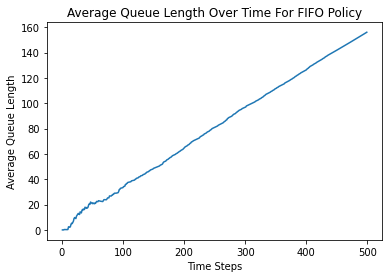

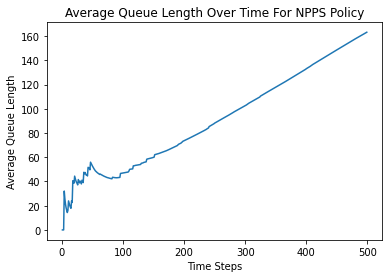

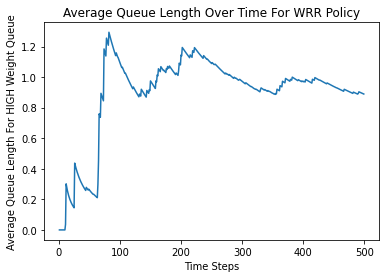

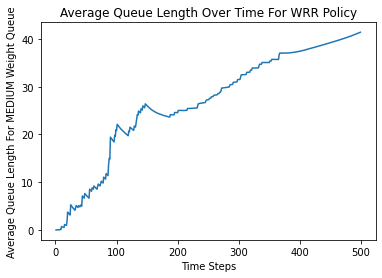

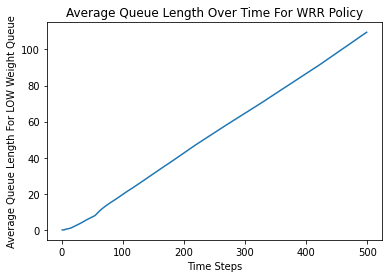

In [204]:
def plot_mean_length_of_queue(tasks, service_policy):
    if service_policy == 'WRR':
        for priority_key, priority_label in priority_labels.items():
            queue_times = []
            time_steps = []
            for i in range(1, T):
                queue_times.append(Task.get_cumulative_queue_time(tasks, i, priority_key) / i)
                time_steps.append(i)
            plt.plot(time_steps, queue_times)
            plt.xlabel('Time Steps')
            plt.ylabel(f'Average Queue Length For {priority_label} Weight Queue')
            plt.title(f'Average Queue Length Over Time For {service_policy} Policy')
            plt.show()
    else:
        queue_times = []
        time_steps = []
        for i in range(1, T):
            queue_times.append(Task.get_cumulative_queue_time(tasks, i, None) / i)
            time_steps.append(i)
        plt.plot(time_steps, queue_times)
        plt.xlabel('Time Steps')
        plt.ylabel('Average Queue Length')
        plt.title(f'Average Queue Length Over Time For {service_policy} Policy')
        plt.show()


plot_mean_length_of_queue(fifo_packets, 'FIFO')
plot_mean_length_of_queue(npps_packets, 'NPPS')
plot_mean_length_of_queue(wrr_packets, 'WRR')

### Mean time wasted in all Queues

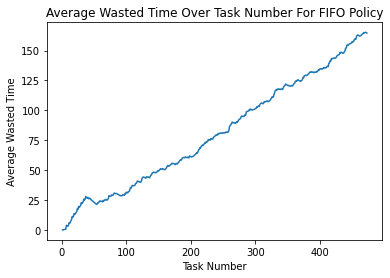

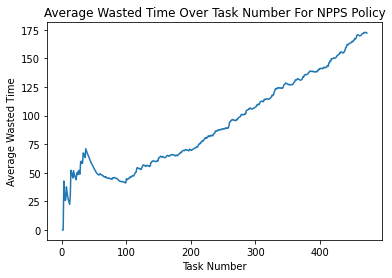

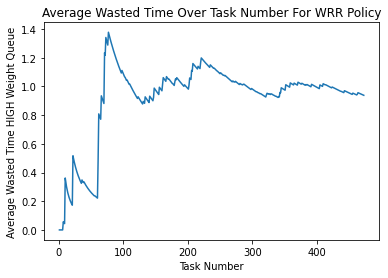

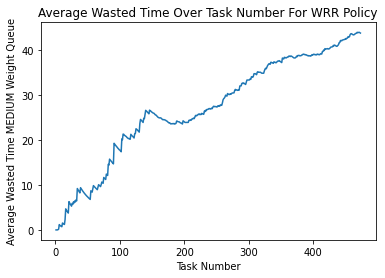

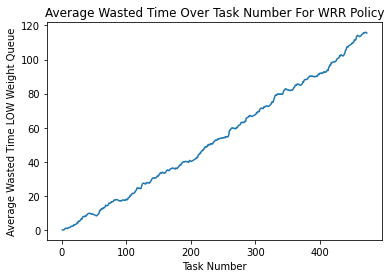

In [205]:
def plot_mean_time_wasted_in_queue(tasks, service_policy):
    if service_policy == 'WRR':
        for priority_key, priority_label in priority_labels.items():
            queue_times = []
            task_number = []
            for i in range(1, len(tasks) + 1):
                queue_times.append(Task.get_cumulative_queue_time(tasks, tasks[i - 1].arrival, priority_key) / i)
                task_number.append(i)
            plt.plot(task_number, queue_times)
            plt.xlabel('Task Number')
            plt.ylabel(f'Average Wasted Time {priority_label} Weight Queue')
            plt.title(f'Average Wasted Time Over Task Number For {service_policy} Policy')
            plt.show()
    else:
        queue_times = []
        task_number = []
        for i in range(1, len(tasks) + 1):
            queue_times.append(Task.get_cumulative_queue_time(tasks, tasks[i - 1].arrival, None) / i)
            task_number.append(i)
        plt.plot(task_number, queue_times)
        plt.xlabel('Task Number')
        plt.ylabel('Average Wasted Time')
        plt.title(f'Average Wasted Time Over Task Number For {service_policy} Policy')
        plt.show()


plot_mean_time_wasted_in_queue(fifo_packets, 'FIFO')
plot_mean_time_wasted_in_queue(npps_packets, 'NPPS')
plot_mean_time_wasted_in_queue(wrr_packets, 'WRR')

### Mean time wasted in each Queue

### Mean Utilization of each processor

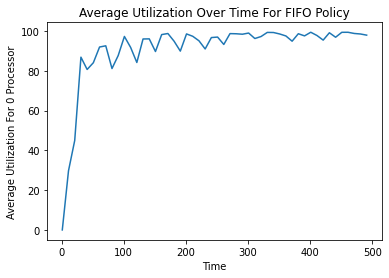

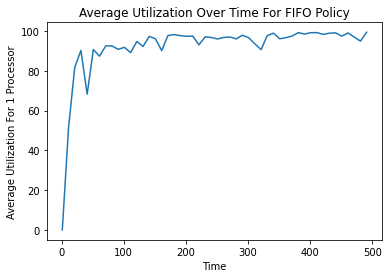

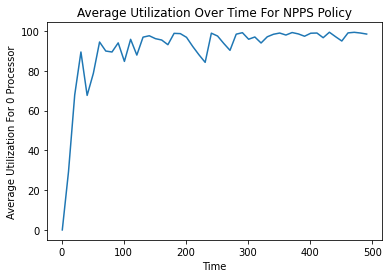

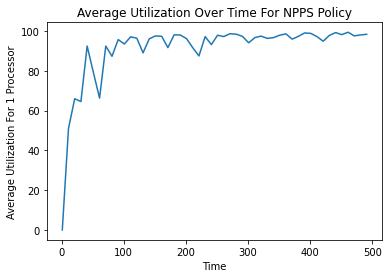

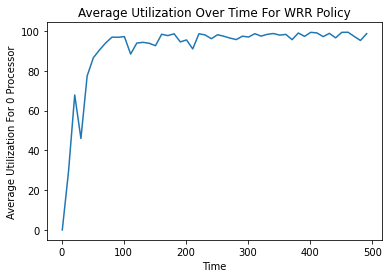

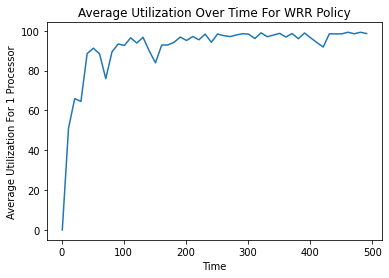

In [209]:
def plot_mean_utilization_for_processor(tasks, service_policy):
    for processor in range(PROCESSORS_NUM):
        utilization_percentages = []
        task_number = []
        for i in range(1, T, 10):
            utilization_percentages.append(Task.get_cumulative_execution_time(tasks, i, processor) / i * 100)
            task_number.append(i)
        plt.plot(task_number, utilization_percentages)
        plt.xlabel('Time')
        plt.ylabel(f'Average Utilization For {processor} Processor')
        plt.title(f'Average Utilization Over Time For {service_policy} Policy')
        plt.show()


plot_mean_utilization_for_processor(fifo_packets, 'FIFO')
plot_mean_utilization_for_processor(npps_packets, 'NPPS')
plot_mean_utilization_for_processor(wrr_packets, 'WRR')

### Number of dropped packages

In [211]:
print(Task.get_number_of_dropped_tasks(fifo_packets), 'are dropped from FIFO Policy')
print(Task.get_number_of_dropped_tasks(wrr_packets), 'are dropped from WRR Policy')
print(Task.get_number_of_dropped_tasks(npps_packets), 'are dropped from NPPS Policy')

289 are dropped from FIFO Policy
257 are dropped from WRR Policy
292 are dropped from NPPS Policy


### How can we increase the utilization of the system?

Answer:

### CDF Plots of high-priority Packages

### Which of the Queuing Poilicies (3 policies) is better regarding the "number of dropped packages" and "number of packages received by the Host"?

Answer: